In [2]:
import numpy as np
import gym
from gym import spaces
import ray
from ray.rllib import agents
from ray.rllib.utils import try_import_tf
from copy import deepcopy
import matplotlib.pyplot as plt
import time
%matplotlib inline
tf = try_import_tf()

ray.init(ignore_reinit_error=True)

2020-05-12 16:37:33,105	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-12 16:37:33,106	INFO resource_spec.py:216 -- Starting Ray with 6.1 GiB memory available for workers and up to 3.08 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.0.11',
 'redis_address': '192.168.0.11:27795',
 'object_store_address': '/tmp/ray/session_2020-05-12_16-37-33_104836_29350/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-05-12_16-37-33_104836_29350/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2020-05-12_16-37-33_104836_29350'}

In [61]:
class ExampleBanditEnv(gym.Env):
    '''
    Bandit Env to elicit nan output from ray for multiple action
    spaces. Has multiple bandits which can make "stronger" pulls 
    at each time step (from 0-F). Just a contrived toy problem to help debug.
    
    Actions:
        Array corresponding to K bandits with values from 0-F to
        represent the force of the pull. Stronger pulls serve as a
        multiplier on the reward.
    State:
        Value corresponding one of N equally probably distributions 
        for the bandit to choose from. 
    '''
    def __init__(self, *args, **kwargs):
        self.reward_scale = 1
        self.num_bandits = 4
#         self.F = 10
        self.F = np.array([10, 20, 30, 40])
        self.num_distributions = 20
        self.means = np.random.randint(80, 100, size=self.num_distributions)
        self.step_limit = 50
        self.action_space = spaces.Box(
            low=np.zeros(self.num_bandits), high=self.F,
            dtype=np.int16)
        self.observation_space = spaces.Box(0, self.num_distributions, 
            shape=(self.num_bandits,), dtype=np.int16)
        
        self.reset()
        
    def reset(self):
        self.time_step = 0
        self.state = self._update_state()
        return self.state
    
    def _update_state(self):
        # Select from action distributions
        return np.random.choice(np.arange(self.num_distributions), size=self.num_bandits)
    
    def step(self, action):
        self._check_action(action)
        reward = sum([i*np.random.normal(loc=self.means[j], scale=20) 
            for i, j in zip(action, self.state)])*self.reward_scale
        self.time_step += 1
        done = True if self.time_step == self.step_limit else False
        return self._update_state(), reward, done, {}
    
    def _check_action(self, action):
        # Raise errors if NaN's found in action space
        if any([np.isnan(i) for i in action]):
            raise ValueError("NaN found in action." +
                "\nAction = {}\nState = {}".format(action, self.state))
        

In [62]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent_(algo='a3c', iters=10, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=ExampleBanditEnv)
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
#         print(pretty_print(result))
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [63]:
trainer, results = train_agent_('a3c', iters=50, 
    config_dict={'timesteps_per_iteration': 1000})

2020-05-12 17:49:40,534	WARNING util.py:45 -- Install gputil for GPU system monitoring.


{'cur_lr': 9.999999747378752e-05, 'policy_loss': 73812.66, 'policy_entropy': 40.637054, 'var_gnorm': 22.929361, 'vf_loss': 14447234.0, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 7.748604e-06}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 19558.82, 'policy_entropy': 10.315365, 'var_gnorm': 23.314722, 'vf_loss': 46595560.0, 'model': {}, 'grad_gnorm': 39.999996, 'vf_explained_var': 1.6748905e-05}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -6576.568, 'policy_entropy': -0.038950562, 'var_gnorm': 23.456684, 'vf_loss': 55113704.0, 'model': {}, 'grad_gnorm': 40.000004, 'vf_explained_var': 5.9604645e-07}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -31738.967, 'policy_entropy': -9.619993, 'var_gnorm': 23.541828, 'vf_loss': 83201130.0, 'model': {}, 'grad_gnorm': 40.00001, 'vf_explained_var': -5.9604645e-07}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -9553.988, 'policy_entropy': -1.2410578, 'var_gnorm': 23.654797, 'vf_loss': 49375404.0, 'model': {}, 'grad_gnorm': 39.9

{'cur_lr': 9.999999747378752e-05, 'policy_loss': -488546.47, 'policy_entropy': -68.247635, 'var_gnorm': 40.265568, 'vf_loss': 385753630.0, 'model': {}, 'grad_gnorm': 40.00003, 'vf_explained_var': 0.0}
Iter:	40	Mean Rewards:	70814.7	Eps per second:	25.118	Total Time (s):	217.3
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -518278.97, 'policy_entropy': -79.628105, 'var_gnorm': 40.838966, 'vf_loss': 351018370.0, 'model': {}, 'grad_gnorm': 39.99994, 'vf_explained_var': 1.1920929e-07}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -445809.97, 'policy_entropy': -71.182556, 'var_gnorm': 41.32085, 'vf_loss': 335024700.0, 'model': {}, 'grad_gnorm': 40.00007, 'vf_explained_var': 0.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -551923.8, 'policy_entropy': -72.58607, 'var_gnorm': 41.82508, 'vf_loss': 377445150.0, 'model': {}, 'grad_gnorm': 39.99998, 'vf_explained_var': 0.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -592476.7, 'policy_entropy': -77.75904, 'var_gnorm': 42.4706, 'vf

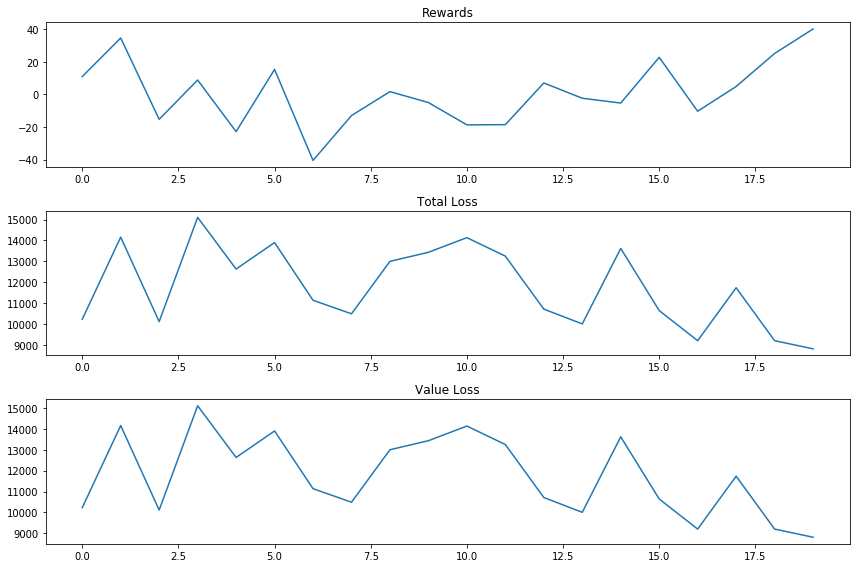

In [37]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['default_policy']['total_loss'] for i in results]
value_loss = [i['info']['learner']['default_policy']['vf_loss'] for i in results]
fig, ax = plt.subplots(3, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Total Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

In [38]:
from or_gym.algos.rl_utils import create_env

def train_agent(env_name, algo='a3c', iters=10, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, env=create_env(env_name))
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
#         print(pretty_print(result))
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [44]:
trainer, results = train_agent('InvManagement-v0', iters=20)

2020-05-12 17:24:11,915	WARNING util.py:45 -- Install gputil for GPU system monitoring.


{'cur_lr': 9.999999747378752e-05, 'policy_loss': -3245.83, 'policy_entropy': 55.526913, 'var_gnorm': 22.790073, 'vf_loss': 21047.312, 'model': {}, 'grad_gnorm': 40.000004, 'vf_explained_var': 0.003240168}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -18198.205, 'policy_entropy': 127.84479, 'var_gnorm': 23.402002, 'vf_loss': 121784.4, 'model': {}, 'grad_gnorm': 40.000008, 'vf_explained_var': 0.001749754}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -512.65796, 'policy_entropy': 35.00043, 'var_gnorm': 23.788662, 'vf_loss': 5871.6357, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': -0.82045853}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 4101.243, 'policy_entropy': 134.05338, 'var_gnorm': 24.142603, 'vf_loss': 6209.381, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': -0.8994545}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -1757.9678, 'policy_entropy': 11.55372, 'var_gnorm': 24.23368, 'vf_loss': 4940.0215, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': 0.7

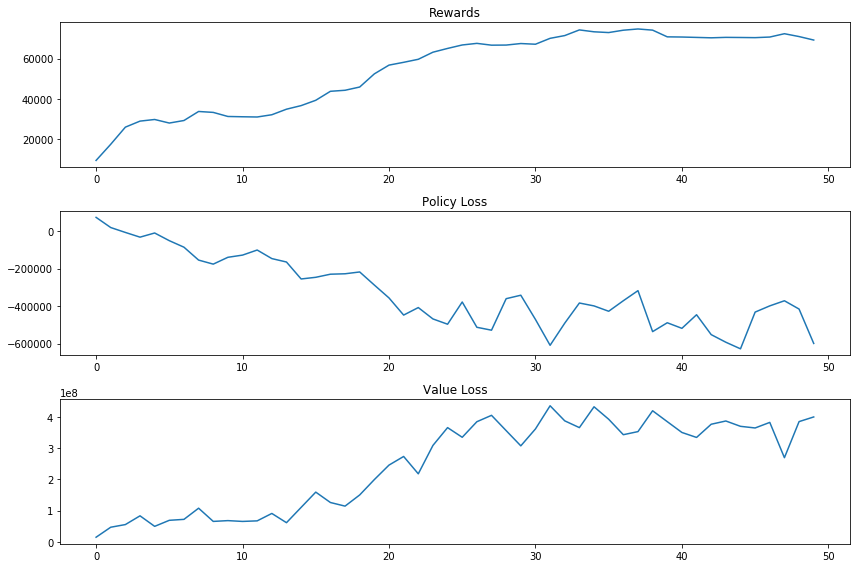

In [64]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]
fig, ax = plt.subplots(3, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(np.array(policy_loss))
ax[1].set_title('Policy Loss')
# ax[1].semilogy()
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

In [51]:
trainer.compute_action(trainer.env_creator({}).reset())

array([nan, nan, nan], dtype=float32)

In [54]:
trainer.config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_batch_size': 10,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 200,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_preprocessor': None,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {}},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': 'InvManagementBacklogEnv',
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0001,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_start': No